### Bangla Speech Emotion Recognition : A study on PCA, ICA and LDA based Machine Learning Model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import math

import librosa
import librosa.display
import IPython.display as ipd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
subesco = glob("SUBESCO/*.wav")

In [3]:
len(subesco)

7000

### Data Preprocessing

In [4]:
# Amplitude Envelop
def amplitude_envelop(signal, frame_size, hop_length):

    # Calculate amplitude envelop
    amplitude_envelop = []
    for i in range(0, len(signal), hop_length):
        calculate_frame_amplitude_envelop = max(signal[i : i + frame_size])
        amplitude_envelop.append(calculate_frame_amplitude_envelop)
    return np.array(amplitude_envelop)

In [5]:
# Root Mean Square Energy
def rms(signal, frame_size, hop_length):
    rms = []
    for i in range(0, len(signal), hop_length):
        calculate_each_frame_rms = np.sqrt(np.sum(signal[i : i+frame_size]**2 )/ frame_size)
        rms.append(calculate_each_frame_rms)
    return np.array(rms)

In [6]:
# Zero Crossing Rate
def zcr(signal, frame_size, hop_length):
    zcr = librosa.feature.zero_crossing_rate(signal, frame_length = frame_size, hop_length = hop_length)[0]
    return zcr

In [7]:
# Band Energy Ratio
def calculate_split_frequency_bin(spectrogram, split_frequency, sample_rate):

    frequency_range = sample_rate/2
    frequency_delta_per_bin = frequency_range/ spectrogram.shape[0]

    split_frequency_bin = np.floor(split_frequency / frequency_delta_per_bin)

    return int(split_frequency_bin)

def calcualte_band_energy_ratio(spectrogram, split_frequency, sample_rate):
    
    split_frequency_bin = calculate_split_frequency_bin(spectrogram, split_frequency, sample_rate)

    # Move to power spectrogram
    power_spec = (np.abs(spectrogram)**2).T

    band_energy_ratio = []

    #calculate band energy ratio for each frame 
    for frequency_in_frame in power_spec:
        sum_power_low_frequencies = np.sum(frequency_in_frame[:split_frequency_bin])
        sum_power_high_frequencies = np.sum(frequency_in_frame[split_frequency_bin:])

        BER_current_frame = sum_power_low_frequencies/sum_power_high_frequencies

        band_energy_ratio.append(BER_current_frame)
        
    return np.array(band_energy_ratio)

In [8]:
def data_processing(path):
    feature = []
    
    subesco = glob(path)
    
    for file in subesco:
        signal, sr = librosa.load(file)

        # Extract feature 
        # Amplitude envelop
        AE = amplitude_envelop(signal, 1024, 512)
        AE_mean = np.mean(AE)
        AE_median = np.median(AE)
        AE_min = np.min(AE)
        AE_max = np.max(AE)
        AE_std = np.std(AE)

        # Root mean square energy
        RMS = rms(signal, 1024, 512)
        RMS_mean = np.mean(RMS)
        RMS_median = np.median(RMS)
        RMS_min = np.min(RMS)
        RMS_max = np.max(RMS)
        RMS_std = np.std(RMS)

        # Zero crossing rate
        ZCR = zcr(signal, 1024, 512)
        ZCR_mean = np.mean(ZCR)
        ZCR_median = np.median(ZCR)
        ZCR_min = np.min(ZCR)
        ZCR_max = np.max(ZCR)
        ZCR_std = np.std(ZCR)

        # mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=40)
        mel_mean = mel_spectrogram.mean(axis = 1)
        mel_median = np.median(mel_spectrogram, axis=1)
        mel_min = mel_spectrogram.min(axis = 1)
        mel_max = mel_spectrogram.max(axis = 1)
        mel_std = mel_spectrogram.std(axis = 1)

        # MFCC
        mfcc = librosa.feature.mfcc(y = signal, n_mfcc = 40, sr =sr)
        mfcc_mean = mfcc.mean(axis = 1)
        mfcc_median = np.median(mfcc, axis=1)
        mfcc_min = mfcc.min(axis = 1)
        mfcc_max = mfcc.max(axis = 1)
        mfcc_std = mfcc.std(axis = 1)

        # Band Energy Ratio
        spectrogram = librosa.stft(signal, n_fft = 2048, hop_length = 512)
        split_frequency_bin = calculate_split_frequency_bin(spectrogram, 2000, sr)
        ber = calcualte_band_energy_ratio(spectrogram, 2000, sr)
        ber_mean = np.mean(ber)
        ber_median = np.median(ber)
        ber_min = np.min(ber)
        ber_max = np.max(ber)
        ber_std = np.std(ber)

        # Spectral Centroid
        sc = librosa.feature.spectral_centroid(y = signal, sr = sr, n_fft = 2048, hop_length = 512)[0]
        sc_mean = np.mean(sc)
        sc_median = np.median(sc)
        sc_min = np.min(sc)
        sc_max = np.max(sc)
        sc_std = np.std(sc)

        # Spectral Bandwith
        SB = librosa.feature.spectral_bandwidth(y = signal, sr=sr, n_fft=2048, hop_length=512)[0]
        sb_mean = np.mean(SB)
        sb_median = np.median(SB)
        sb_min = np.min(SB)
        sb_max = np.max(SB)
        sb_std = np.std(SB)

        # Combine features into one vector
        feature.append(np.hstack([AE_mean, AE_median, AE_min, AE_max, AE_std, RMS_mean, RMS_median, RMS_min, RMS_max, RMS_std,\
                                 ZCR_mean, ZCR_median, ZCR_min, ZCR_max, ZCR_std, mel_mean, mel_median, mel_min, mel_max, mel_std,\
                                 mfcc_mean, mfcc_median, mfcc_min, mfcc_max, mfcc_std, ber_mean, ber_median, ber_min, ber_max, ber_std,\
                                 sc_mean, sc_median, sc_min, sc_max, sc_std, sb_mean, sb_median, sb_min, sb_max , sb_std]))
    return np.array(feature)

In [9]:
data = data_processing("SUBESCO/*.wav")

In [10]:
data.shape

(7000, 430)

In [11]:
# label
subesco = glob("SUBESCO/*.wav")
label1 = [path.split('\\')[1] for path in subesco]
label = [path.split("_")[-2] for path in label1]
label = np.array(label)

In [12]:
class_labels = np.unique(label)

In [13]:
# Encode label
le = LabelEncoder()
labels_encoded = le.fit_transform(label)

In [14]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data)

### Model

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features_scaled, \
                                                            labels_encoded, test_size=0.2, random_state=203,stratify= labels_encoded)

KNN

In [16]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

KNN_test = knn.predict(x_test)

print("Classification Report:\n", classification_report(y_test, KNN_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       200
           1       0.75      0.72      0.73       200
           2       0.88      0.84      0.86       200
           3       0.82      0.80      0.81       200
           4       0.86      0.95      0.90       200
           5       0.85      0.79      0.82       200
           6       0.81      0.81      0.81       200

    accuracy                           0.83      1400
   macro avg       0.83      0.83      0.83      1400
weighted avg       0.83      0.83      0.83      1400



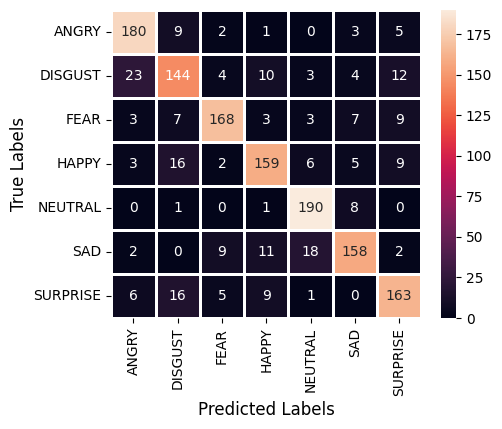

In [17]:
cf_matrix = confusion_matrix(y_test, KNN_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

Decision Tree Classifier

In [18]:
clf = DecisionTreeClassifier(random_state=0, max_depth = 6)

In [19]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

In [20]:
Dtree_test = clf.predict(x_test)

In [21]:
print("Classification Report:\n", classification_report(y_test, Dtree_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.52      0.63       200
           1       0.32      0.40      0.36       200
           2       0.54      0.46      0.50       200
           3       0.39      0.56      0.46       200
           4       0.66      0.60      0.63       200
           5       0.52      0.40      0.45       200
           6       0.38      0.42      0.40       200

    accuracy                           0.48      1400
   macro avg       0.51      0.48      0.49      1400
weighted avg       0.51      0.48      0.49      1400



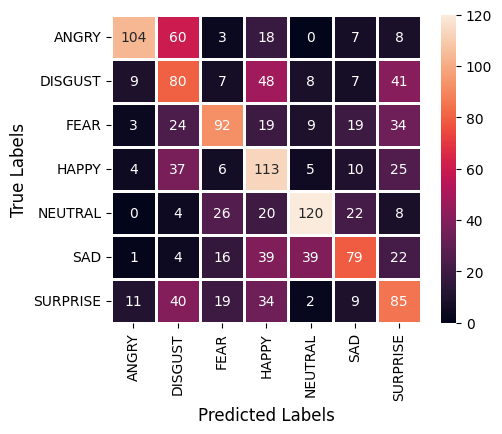

In [22]:
cf_matrix = confusion_matrix(y_test, Dtree_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

Random Forest

In [23]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
rf_test = rf_model.predict(x_test)

In [25]:
print("Classification Report:\n", classification_report(y_test, rf_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       200
           1       0.85      0.72      0.78       200
           2       0.88      0.78      0.83       200
           3       0.79      0.81      0.80       200
           4       0.85      0.96      0.90       200
           5       0.91      0.81      0.86       200
           6       0.74      0.81      0.77       200

    accuracy                           0.83      1400
   macro avg       0.83      0.83      0.83      1400
weighted avg       0.83      0.83      0.83      1400



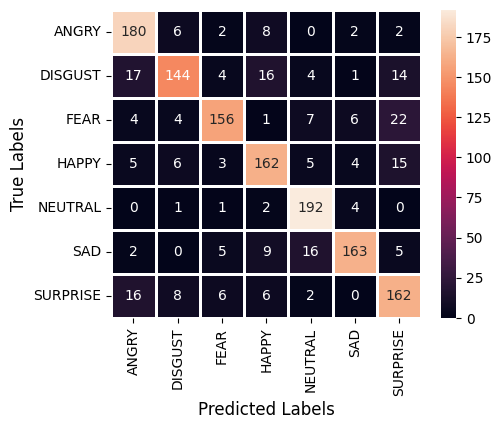

In [26]:
cf_matrix = confusion_matrix(y_test, rf_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

XGBoost

In [27]:
sample_weights = compute_sample_weight(class_weight='balanced', y=labels_encoded)

x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(
    data, labels_encoded, sample_weights, test_size=0.2, random_state=42, stratify= labels_encoded
)
# Compute sample weights to handle imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=labels_encoded)

# Define and train XGBoost model with sample weights
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, objective="multi:softmax", num_class=len(label), random_state=42)
xgb_model.fit(x_train, y_train, sample_weight=w_train)

# Predict on test set
xgb_test = xgb_model.predict(x_test)

In [28]:
print("Classification Report:\n", classification_report(y_test, xgb_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       200
           1       0.90      0.83      0.87       200
           2       0.93      0.86      0.89       200
           3       0.86      0.89      0.88       200
           4       0.90      0.98      0.94       200
           5       0.94      0.84      0.89       200
           6       0.78      0.90      0.83       200

    accuracy                           0.89      1400
   macro avg       0.89      0.89      0.89      1400
weighted avg       0.89      0.89      0.89      1400



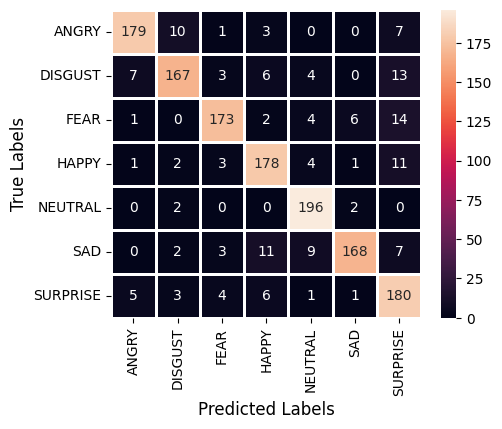

In [29]:
cf_matrix = confusion_matrix(y_test, xgb_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

### PCA(85%) ICA(15) and LDA(6)

In [30]:
def apply_pca_ica_lda(X, pca_variance=0.85, ica_components= 15 ):

    # Step 1: Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 2: Apply PCA
    pca = PCA(n_components=pca_variance)  
    X_pca = pca.fit_transform(X_scaled)
    print("PCA Output Shape:", X_pca.shape)

    # Step 3: Apply ICA 
    ica = FastICA(n_components= ica_components, random_state=42)
    X_ica = ica.fit_transform(X_scaled)
    print("ICA Output Shape:", X_ica.shape)

    # Step 4: Apply LDA 
    lda = LinearDiscriminantAnalysis(n_components= 6)
    X_lda = lda.fit_transform(X_scaled, labels_encoded)
    print("LDA Output Shape:", X_lda.shape)
    
    return np.hstack([X_pca, X_ica, X_lda])

In [31]:
pca_ica_lda = apply_pca_ica_lda(features_scaled, 0.85, 15)
# split data
x_train, x_test, y_train, y_test = train_test_split(pca_ica_lda, \
                                                            labels_encoded, test_size=0.2, random_state=203,stratify= labels_encoded)

PCA Output Shape: (7000, 65)
ICA Output Shape: (7000, 15)
LDA Output Shape: (7000, 6)


Random Forest

In [32]:
# random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Make predictions
rf_test = rf_model.predict(x_test)

print("Classification Report:\n", classification_report(y_test, rf_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       200
           1       0.81      0.79      0.80       200
           2       0.91      0.86      0.89       200
           3       0.85      0.89      0.87       200
           4       0.88      0.97      0.93       200
           5       0.93      0.82      0.87       200
           6       0.80      0.82      0.81       200

    accuracy                           0.86      1400
   macro avg       0.86      0.86      0.86      1400
weighted avg       0.86      0.86      0.86      1400



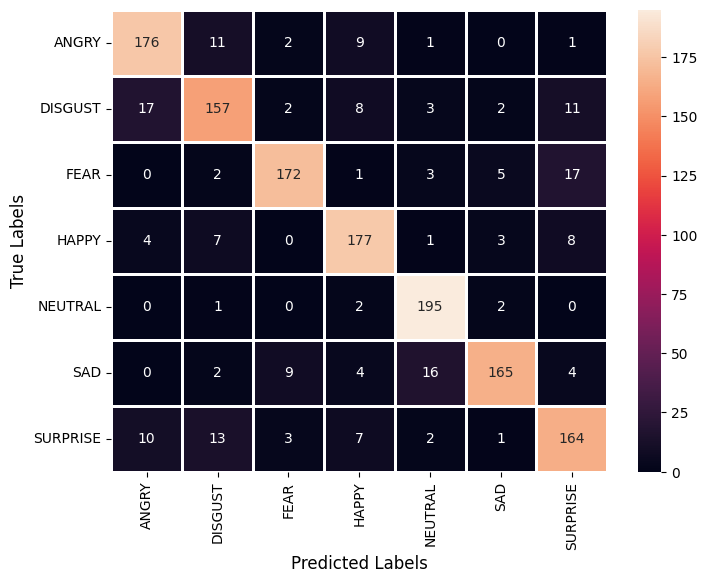

In [33]:
cf_matrix = confusion_matrix(y_test, rf_test)
fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

### PCA(90) ICA(35) LDA(6)

In [34]:
pca_ica_lda = apply_pca_ica_lda(features_scaled, 0.90, 35)
# split data
x_train, x_test, y_train, y_test = train_test_split(pca_ica_lda, \
                                                            labels_encoded, test_size=0.2, random_state=203,stratify= labels_encoded)

PCA Output Shape: (7000, 96)
ICA Output Shape: (7000, 35)
LDA Output Shape: (7000, 6)


KNN

In [35]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)

knn_test = knn.predict(x_test)

print("Classification Report:\n", classification_report(y_test, knn_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       200
           1       0.80      0.78      0.79       200
           2       0.90      0.85      0.88       200
           3       0.86      0.82      0.84       200
           4       0.87      0.94      0.90       200
           5       0.86      0.82      0.84       200
           6       0.84      0.84      0.84       200

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400



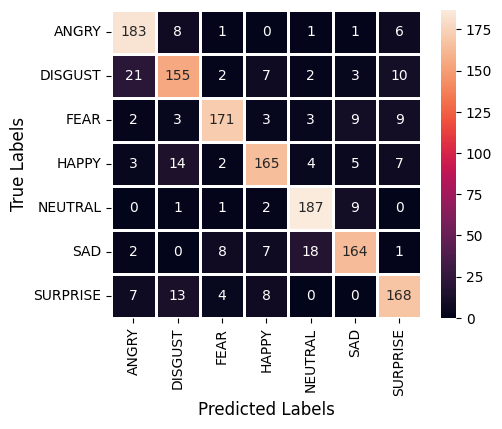

In [36]:
cf_matrix = confusion_matrix(y_test, knn_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

### PCA(75) ICA(40) LDA(6)

In [37]:
pca_ica_lda = apply_pca_ica_lda(features_scaled, 0.75, 40)
# split data
x_train, x_test, y_train, y_test = train_test_split(pca_ica_lda, \
                                                            labels_encoded, test_size=0.2, random_state=203,stratify= labels_encoded)

PCA Output Shape: (7000, 32)
ICA Output Shape: (7000, 40)
LDA Output Shape: (7000, 6)


Decisition Tree

In [38]:
# Desition Tree Classifier
clf = DecisionTreeClassifier(random_state=0, max_depth = 6)
clf.fit(x_train, y_train)

#predict
Dtree_test = clf.predict(x_test)

print("Classification Report:\n", classification_report(y_test, Dtree_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       200
           1       0.62      0.61      0.61       200
           2       0.89      0.79      0.84       200
           3       0.69      0.84      0.76       200
           4       0.81      0.88      0.84       200
           5       0.76      0.71      0.74       200
           6       0.71      0.67      0.69       200

    accuracy                           0.75      1400
   macro avg       0.75      0.75      0.75      1400
weighted avg       0.75      0.75      0.75      1400



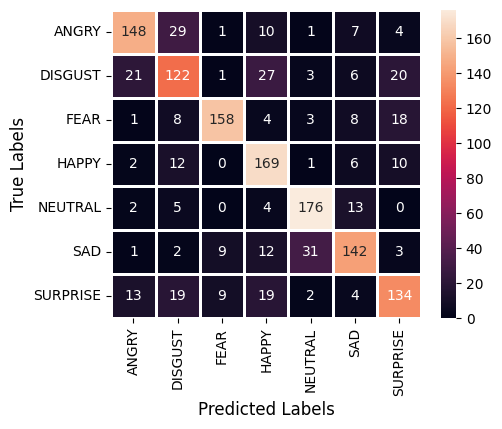

In [39]:
cf_matrix = confusion_matrix(y_test, Dtree_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

### PCA(50) ICA(30) LDA(6)

In [40]:
pca_ica_lda = apply_pca_ica_lda(features_scaled, 0.50, 30)

PCA Output Shape: (7000, 7)
ICA Output Shape: (7000, 30)
LDA Output Shape: (7000, 6)


XGBoost

In [41]:
sample_weights = compute_sample_weight(class_weight='balanced', y=labels_encoded)

x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(
    pca_ica_lda, labels_encoded, sample_weights, test_size=0.2, random_state=42, stratify= labels_encoded
)
# Compute sample weights to handle imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=labels_encoded)

# Define and train XGBoost model with sample weights
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, objective="multi:softmax", num_class=len(label), random_state=42)
xgb_model.fit(x_train, y_train, sample_weight=w_train)

# Predict on test set
xgb_test = xgb_model.predict(x_test)

print("Classification Report:\n", classification_report(y_test, xgb_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       200
           1       0.82      0.80      0.81       200
           2       0.91      0.85      0.88       200
           3       0.83      0.82      0.83       200
           4       0.89      0.94      0.91       200
           5       0.82      0.79      0.81       200
           6       0.78      0.81      0.79       200

    accuracy                           0.84      1400
   macro avg       0.85      0.84      0.84      1400
weighted avg       0.85      0.84      0.84      1400



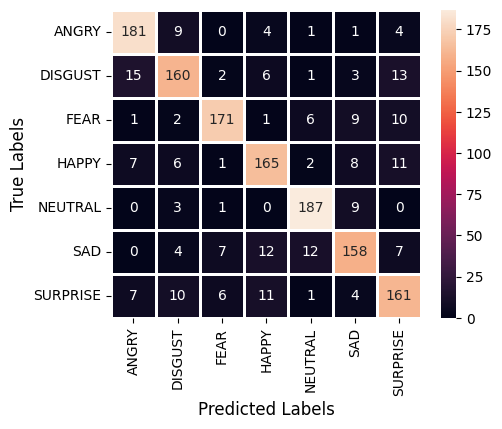

In [42]:
cf_matrix = confusion_matrix(y_test, xgb_test)
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')
ax.set_xticklabels(class_labels, rotation = 90)
ax.set_yticklabels(class_labels, rotation = 360)
ax.set_xlabel("Predicted Labels", fontsize=12)
ax.set_ylabel("True Labels", fontsize=12)
plt.show()

### Emotion Accuracy Plot

Without Data Reduction

In [13]:
row_dict = {"Emotion" : ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"],
      "KNN" : [86, 73, 86, 81, 90, 82, 81],
      "D-TREE" : [63, 36, 50, 46, 63, 45, 40],
      "RF" : [85, 78, 83, 80, 90, 86, 77],
      "XGBoost" : [91, 87, 89, 88, 94, 89, 83]}

In [14]:
row = pd.DataFrame(row_dict)
row

,Emotion,KNN,D-TREE,RF,XGBoost
0,ANGRY,86,63,85,91
1,DISGUST,73,36,78,87
2,FEAR,86,50,83,89
3,HAPPY,81,46,80,88
4,NEUTRAL,90,63,90,94
5,SAD,82,45,86,89
6,SURPRISE,81,40,77,83


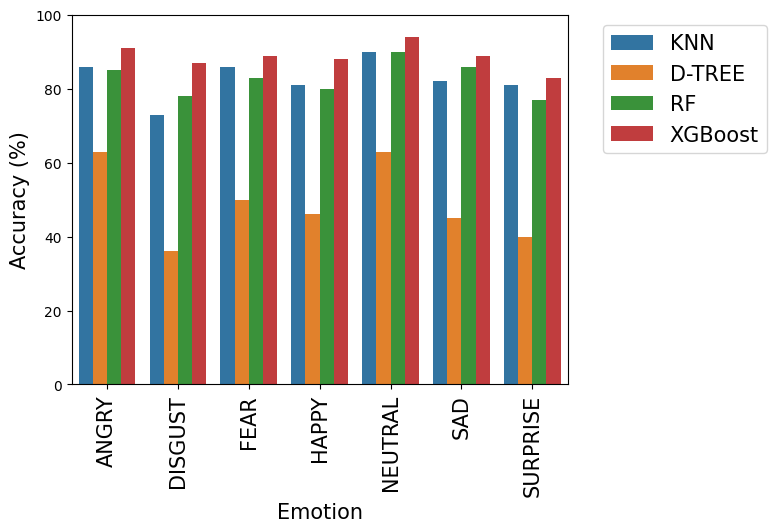

In [15]:
row_melt = row.melt(id_vars = "Emotion", var_name = "Model", value_name = "Accuracy")
sns.barplot(x = "Emotion", y = "Accuracy", data = row_melt, hue = "Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 15)
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks([0,20,40,60,80,100])
plt.ylabel("Accuracy (%)", fontsize = 15)
plt.xlabel("Emotion", fontsize = 15)
plt.savefig("ROW_SUBESCO.png", bbox_inches='tight')
plt.show()

With Data Reduction

In [16]:
reduction_dict = {"Emotion" : ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"],
      "KNN" : [88, 79, 88, 84, 90, 84, 84],
      "D-TREE" : [76, 61, 84, 76, 84, 74, 69],
      "RF" : [86, 80, 89, 87, 93, 87, 81],
      "XGBoost" : [88, 81, 88, 83, 91, 81, 79]}
reduction = pd.DataFrame(reduction_dict)
reduction

,Emotion,KNN,D-TREE,RF,XGBoost
0,ANGRY,88,76,86,88
1,DISGUST,79,61,80,81
2,FEAR,88,84,89,88
3,HAPPY,84,76,87,83
4,NEUTRAL,90,84,93,91
5,SAD,84,74,87,81
6,SURPRISE,84,69,81,79


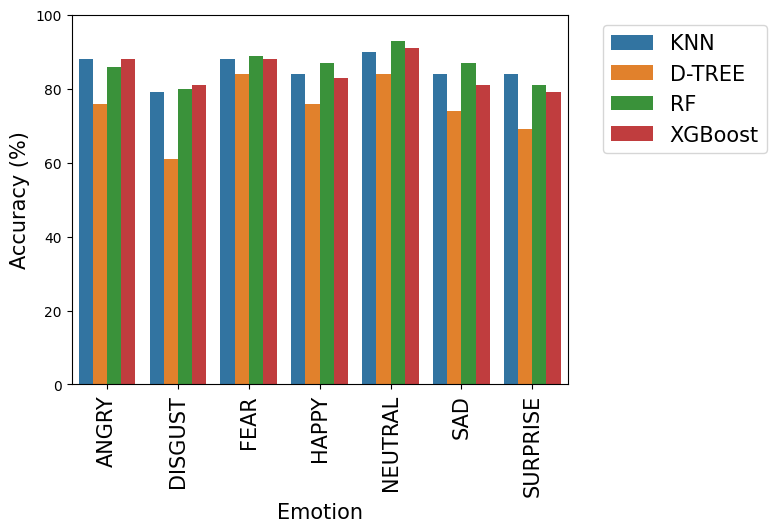

In [17]:
reduction_melt = reduction.melt(id_vars = "Emotion", var_name = "Model", value_name = "Accuracy")
sns.barplot(x = "Emotion", y = "Accuracy", data = reduction_melt, hue = "Model")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 15)
plt.xticks(rotation = 90, fontsize = 15)
plt.yticks([0,20,40,60,80,100])
plt.ylabel("Accuracy (%)", fontsize = 15)
plt.xlabel("Emotion", fontsize = 15)
plt.savefig("Reduction_SUBESCO.png", bbox_inches='tight')
plt.show()